In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,Conv2DTranspose,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [3]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
im_size=x_train.shape[1]
x_train = np.reshape(x_train,[-1,im_size,im_size,1])
x_test = np.reshape(x_test,[-1,im_size,im_size,1])
x_train = x_train/255
x_test = x_test/255


In [4]:
##### create a new noisy data
noise1 = np.random.normal(loc=0.5,scale=0.5,size=x_train.shape) #noise with mean and std 0.5
x_train_noise = x_train+ noise1
noise2 = np.random.normal(loc=0.5,scale=0.5,size=x_test.shape)
x_test_noise = x_test+noise2

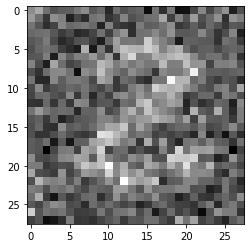

In [5]:
plt.imshow(np.reshape(x_train_noise[25],(28,28)),cmap='gray')

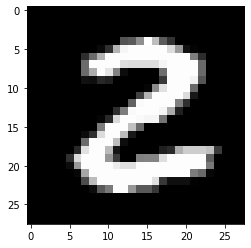

In [6]:
plt.imshow(np.reshape(x_train[25],(28,28)),cmap='gray')

In [7]:
#due to noise addition some pixels may have exceeded 1 while some may have been less than 0.Hence correcting by clipping
x_train_noise = np.clip(x_train_noise,0,1) #less than 0 become 0 and greater than one become one.
x_test_noise = np.clip(x_test_noise,0,1)

In [8]:
ip_shape = (im_size,im_size,1)
layers=[32,64]
inputs = Input(shape=ip_shape,name='encoder_ip')
x=inputs
for layer in layers:
    x = Conv2D(layer,kernel_size=3,strides=2,padding='same',activation='relu')(x) #2 stride with same padding makes img dims half
shape = K.int_shape(x) # would be (b_size,7,7,64) for MNIST
#now flatten it
x = Flatten()(x)
#now add dense layer to make it latent dimensional encoded.
latent = Dense(20,name='latent_vec')(x) #don't add relu here.(we need the latent vector itself)

encoder = Model(inputs,latent,name='encoder')

In [9]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_ip (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vec (Dense)           (None, 20)                62740     
Total params: 81,556
Trainable params: 81,556
Non-trainable params: 0
_________________________________________________________________


In [10]:
latent_ip = Input(shape=(20,),name='decoder_ip')
y = latent_ip
y = Dense(shape[1]*shape[2]*shape[3])(y)
y = Reshape((shape[1],shape[2],shape[3]))(y)
for layer in layers[::-1]:
    y = Conv2DTranspose(filters=layer,kernel_size=3,activation='relu',strides=2,padding='same')(y) #this would double img width,h, half the depth
#now shape would be 28*28*32
op = Conv2DTranspose(filters=1,padding='same',kernel_size=3,activation='sigmoid')(y)#this gives 28*28*1


In [11]:
decoder = Model(latent_ip,op,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_ip (InputLayer)      [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              65856     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 121,537
Trainable params: 121,537
Non-trainable params: 0
_____________________________________________________

In [12]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_ip (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 20)                81556     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         121537    
Total params: 203,093
Trainable params: 203,093
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(optimizer='adam',loss='mse')

In [14]:
autoencoder.fit(x_train_noise,x_train,validation_data=(x_test_noise,x_test),epochs=15,batch_size=32) #validate with x_test,x_test(as we want same ip)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 34s 561us/sample - loss: 0.0333 - val_loss: 0.0184
Epoch 2/15
60000/60000 [==============================] - 29s 485us/sample - loss: 0.0172 - val_loss: 0.0161
Epoch 3/15
60000/60000 [==============================] - 29s 484us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 4/15
60000/60000 [==============================] - 29s 485us/sample - loss: 0.0151 - val_loss: 0.0150
Epoch 5/15
60000/60000 [==============================] - 30s 492us/sample - loss: 0.0147 - val_loss: 0.0147
Epoch 6/15
60000/60000 [==============================] - 30s 492us/sample - loss: 0.0143 - val_loss: 0.0147
Epoch 7/15
60000/60000 [==============================] - 30s 508us/sample - loss: 0.0141 - val_loss: 0.0145
Epoch 8/15
60000/60000 [==============================] - 30s 506us/sample - loss: 0.0139 - val_loss: 0.0144
Epoch 9/15
60000/60000 [==============================] - 31s 522us/sample - l

In [15]:
decoded_x = autoencoder.predict(x_test_noise)

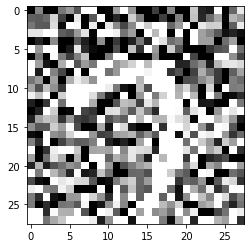

In [25]:
plt.imshow(np.reshape(x_test_noise[26],(28,28)),cmap='gray') #noisy input

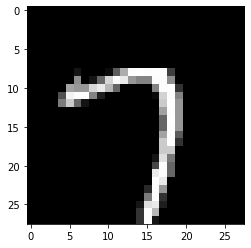

In [26]:
plt.imshow(np.reshape(x_test[26],(28,28)),cmap='gray') #og output

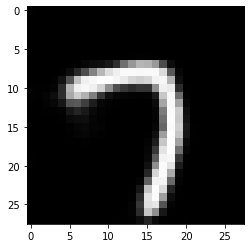

In [27]:
plt.imshow(np.reshape(decoded_x[26],(28,28)),cmap='gray') # op generated by autoencoder.